In [38]:
import pandas as pd
import functions as func
import pickle
import xgboost as xgb
from patsy import dmatrices
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae



In [56]:
api_url = 'https://gamesheetstats.com/api/useScoredGames/getSeasonScores/6642?filter[limit]=10000'
# api_url = 'https://gamesheetstats.com/api/useScoredGames/getSeasonScores/6775?filter[limit]=10000'
df_season1 = func.parse_rest_api_to_pandas(api_url)

df_season1 = df_season1[['date','game.number','game.type','game.gameId','game.homeTeam.id','game.homeTeam.name','game.homeTeam.division','game.visitorTeam.id','game.visitorTeam.name','game.visitorTeam.division','game.finalScore.homeGoals','game.finalScore.visitorGoals']]
df_season1 = df_season1.rename(columns={'game.number':'game_number','game.type':'game_type','game.gameId':'game_id','game.homeTeam.id':'hometeam_id','game.homeTeam.name':'hometeam_name','game.homeTeam.division':'hometeam_division','game.visitorTeam.id':'visitorteam_id','game.visitorTeam.name':'visitorteam_name','game.visitorTeam.division':'visitorteam_division','game.finalScore.homeGoals':'homegoals','game.finalScore.visitorGoals':'visitorgoals'})
df_season1.head(5)

,date,game_number,game_type,game_id,hometeam_id,hometeam_name,hometeam_division,visitorteam_id,visitorteam_name,visitorteam_division,homegoals,visitorgoals
0,"Sat, Feb 15, 2025",None,Regular Season,2248963,248315,Cyclones Academy 14U Tier 1,14U Tier 1,248128,Seacoast Performance Academy Spartans 14U,14U Tier 1,0,8
1,"Sat, Feb 15, 2025",6950204,Regular Season,2238756,251274,Northern Cyclones Squirt Minor Gold,10U Tier 4,248303,Keene 10U White,10U Tier 4,6,4
2,"Sat, Feb 15, 2025",6703687,Regular Season,1941510,248474,Manchester 12U Major II - Engvik,12U Tier 3,248475,Manchester 12U Minor I - Hawkes,12U Tier 3,9,3
3,"Sat, Feb 15, 2025",6749225,Regular Season,2244541,248654,Concord 11U Elite - Poirier,12U Tier 4,250808,Granite State Wild PW Minor 11U,12U Tier 4,1,9
4,"Sat, Feb 15, 2025",6694611,Regular Season,1941221,251301,Upper Valley 10u Blue,10U Tier 3,248656,Berlin 10U Paiva,10U Tier 3,5,5


In [57]:
# Reverse home & visitor team metrics to get a full dataset
df_season2 = df_season1.rename(columns={'hometeam_id':'visitorteam_id','hometeam_name':'visitorteam_name','hometeam_division':'visitorteam_division','visitorteam_id':'hometeam_id','visitorteam_name':'hometeam_name','visitorteam_division':'hometeam_division','homegoals':'visitorgoals','visitorgoals':'homegoals'})
df_season1['keep']='1'
df_season2['keep']='0'

df_season = pd.concat([df_season1, df_season2], ignore_index=True, axis=0, join="inner")
del df_season2

df_season['goal_diff'] = df_season['homegoals'] - df_season['visitorgoals']

# SET COLUMN TYPES
for col in df_season.columns.to_list():
    if col in ('homegoals','visitorgoals','goal_diff'):
        df_season[col] = pd.to_numeric(df_season[col])
    elif col =='date':
        df_season[col] = pd.to_datetime(df_season[col])
    else:
        df_season[col] = df_season[col].astype('category')
        
df_season.dtypes

date                    datetime64[ns]
game_number                   category
game_type                     category
game_id                       category
hometeam_id                   category
hometeam_name                 category
hometeam_division             category
visitorteam_id                category
visitorteam_name              category
visitorteam_division          category
homegoals                        int64
visitorgoals                     int64
keep                          category
goal_diff                        int64
dtype: object

In [58]:
# GLM: Poisson (Home Goals)
glm_forumula = (''' homegoals ~ hometeam_id + visitorteam_id ''')

y, X = dmatrices(glm_forumula, data=df_season, return_type='dataframe')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=1)


glm_P = PoissonRegressor( alpha=0, solver='lbfgs', max_iter=1000, verbose=0)
glm_P.fit(X_train, y_train['homegoals'])

pred = pd.DataFrame(glm_P.predict(X), columns=['pred_home'])
out = pd.concat([df_season, pred], axis=1)

# Apply visitor team predictions
out2 = out[['game_id', 'visitorteam_id', 'pred_home']].rename(columns={'visitorteam_id': 'hometeam_id', 'pred_home': 'pred_visitor'})
out_full = pd.merge(out, out2, on=['game_id', 'hometeam_id'])
del out, out2

# Calculate goal differences and total points
out_full['pred_diff'] = out_full['pred_home'] - out_full['pred_visitor']
out_full['home_points'] = np.where(out_full['homegoals'] > out_full['visitorgoals'], 2, 
                                    np.where(out_full['homegoals'] == out_full['visitorgoals'], 1, 0))
out_full['pred_points'] = np.where(out_full['pred_home'] > out_full['pred_visitor'], 2, 
                                    np.where(out_full['pred_home'] == out_full['pred_visitor'], 1, 0))


print('R2: ', round(r2_score(out_full['goal_diff'], out_full['pred_diff']), 4))
print('MAE: ', round(mae(out_full['goal_diff'], out_full['pred_diff']), 4))

R2:  0.6089
MAE:  2.4198


In [72]:
out_full.groupby('hometeam_division', observed=True)['hometeam_name'].nunique()

hometeam_division
10U Girls Tier 1     2
10U Girls Tier 2     4
10U Tier 1           2
10U Tier 2           4
10U Tier 3           6
10U Tier 4           9
10U Tier 5          11
12U Girls Tier 1     2
12U Girls Tier 2     3
12U Tier 2           2
12U Tier 3          11
12U Tier 4           7
12U Tier 5           8
13O Tier 1           5
14U Girls Tier 2     2
14U Tier 1           3
14U Tier 2           5
14U Tier 3           5
14U Tier 4           9
14U Tier 5           8
15O Tier 1           3
16U Girls Tier 1     2
16U Tier 1           6
16U Tier 2           6
16U Tier 3           5
18U Tier 1           4
18U Tier 2           8
18U Tier 3           7
18U Tier 4           6
Name: hometeam_name, dtype: int64

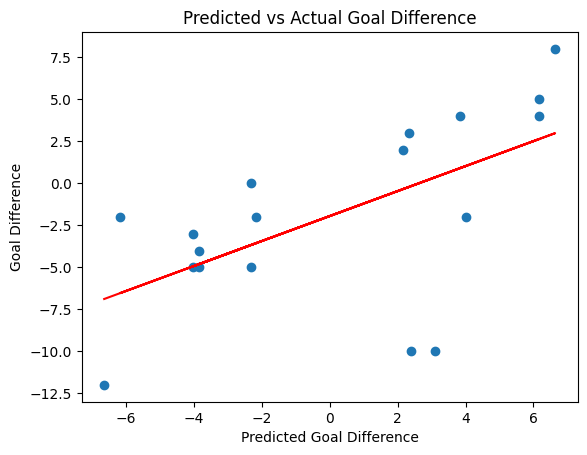

R2:  0.4432
MAE:  2.4992


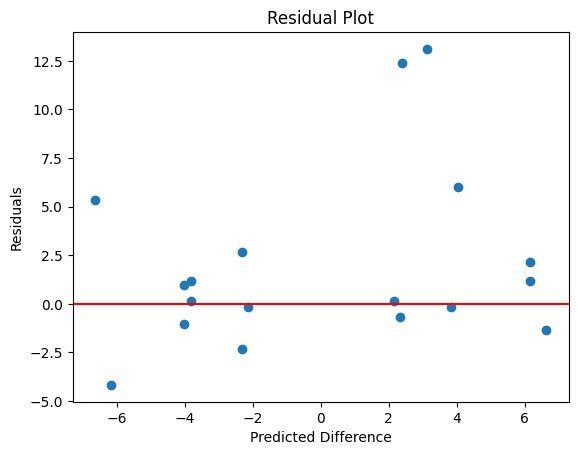

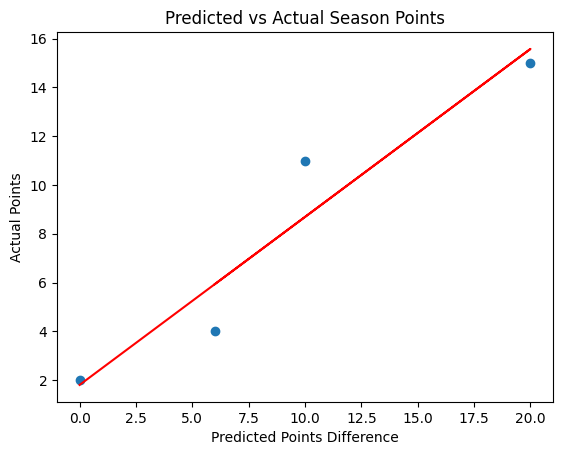

R2:  0.6909
MAE:  2.5


In [80]:
# CHARTS
# out_filter = out_full
out_filter = out_full[(out_full['hometeam_division']=='10U Girls Tier 2')]


# PREDICTED GOALS
out_chart = out_filter[(out_filter['keep'] == '1')]
slope, intercept, rvalue, pvalue, stderr = stats.linregress(out_chart['pred_diff'], out_chart['goal_diff'])

plt.scatter(out_chart['pred_diff'], out_chart['goal_diff'])
plt.plot(out_chart['pred_diff'], intercept + slope*out_chart['pred_diff'], 'r')
plt.xlabel('Predicted Goal Difference')
plt.ylabel('Goal Difference')
plt.title('Predicted vs Actual Goal Difference')
plt.show()

# FILTERED METRICS
print('R2: ', round(r2_score(out_filter['goal_diff'], out_filter['pred_diff']), 4))
print('MAE: ', round(mae(out_filter['goal_diff'], out_filter['pred_diff']), 4))


# RESIDUALS
residuals = out_chart['pred_diff'] - out_chart['goal_diff']

plt.scatter(out_chart['pred_diff'], residuals)
plt.xlabel('Predicted Difference')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()


# PREDICTED POINTS
out_chart = out_filter.groupby('hometeam_name', observed=True).agg({'home_points':'sum', 'pred_points':'sum'}).reset_index()
slope, intercept, rvalue, pvalue, stderr = stats.linregress(out_chart['pred_points'], out_chart['home_points'])

plt.scatter(out_chart['pred_points'], out_chart['home_points'])
plt.plot(out_chart['pred_points'], intercept + slope*out_chart['pred_points'], 'r')
plt.xlabel('Predicted Points Difference')
plt.ylabel('Actual Points')
plt.title('Predicted vs Actual Season Points')
plt.show()

# FILTERED METRICS
print('R2: ', round(r2_score(out_chart['home_points'], out_chart['pred_points']), 4))
print('MAE: ', round(mae(out_chart['home_points'], out_chart['pred_points']), 4))

TEST CODE / OLD CODE

R2:  0.2072
MAE:  3.3139


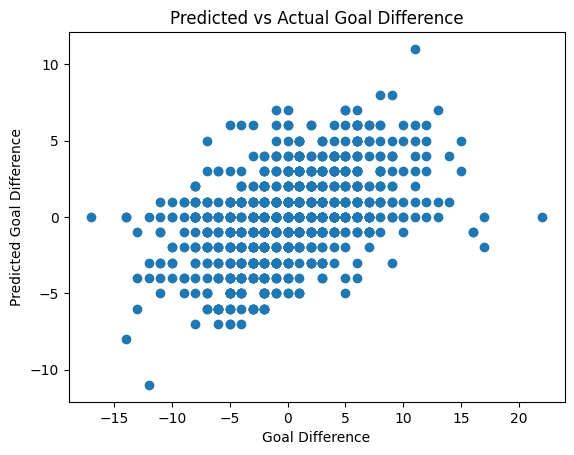

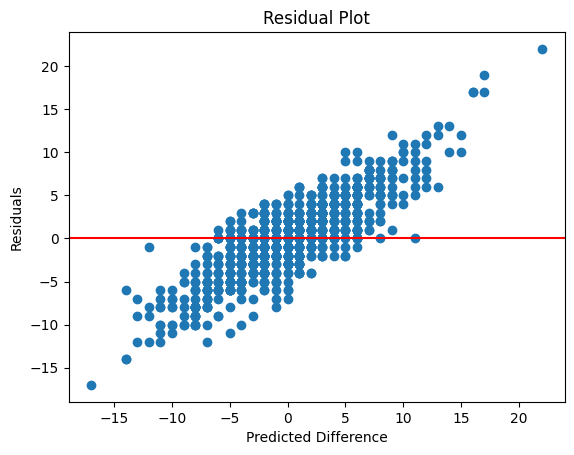

In [43]:
# GLM: Logistic (Home Goals)
glm_forumula = (''' homegoals ~ hometeam_id + visitorteam_id ''')

y, X = dmatrices(glm_forumula, data=df_season, return_type='dataframe')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=1)


glm_Log = LogisticRegression()
glm_Log.fit(X_train, y_train['homegoals'])

pred = pd.DataFrame(glm_Log.predict(X), columns=['pred_home'])
out = pd.concat([df_season, pred], axis=1)


out2 = out[['game_id', 'visitorteam_id', 'pred_home']].rename(columns={'visitorteam_id': 'hometeam_id', 'pred_home': 'pred_visitor'})
out_full = pd.merge(out, out2, on=['game_id', 'hometeam_id'])
del out, out2

out_full['pred_diff'] = out_full['pred_home'] - out_full['pred_visitor']
out_full = out_full[(out_full['keep'] == '1')]


print('R2: ', round(r2_score(out_full['goal_diff'], out_full['pred_diff']), 4))
print('MAE: ', round(mae(out_full['goal_diff'], out_full['pred_diff']), 4))


plt.scatter(out_full['goal_diff'], out_full['pred_diff'])
plt.xlabel('Goal Difference')
plt.ylabel('Predicted Goal Difference')
plt.title('Predicted vs Actual Goal Difference')
plt.show()


residuals = out_full['goal_diff'] - out_full['pred_diff']

plt.scatter(out_full['goal_diff'], residuals)
plt.xlabel('Predicted Difference')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

R2:  -3.223689102993184e+27
MAE:  73726888897176.84


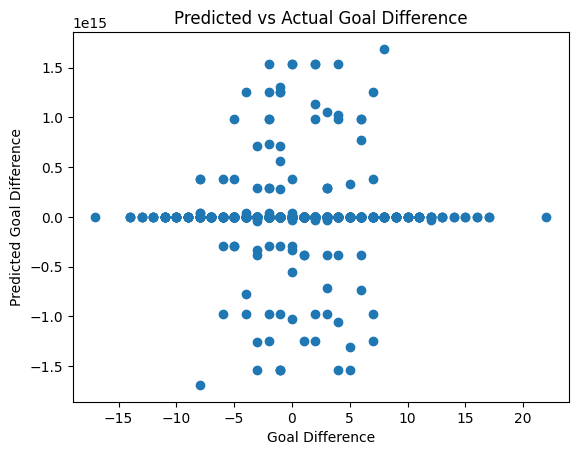

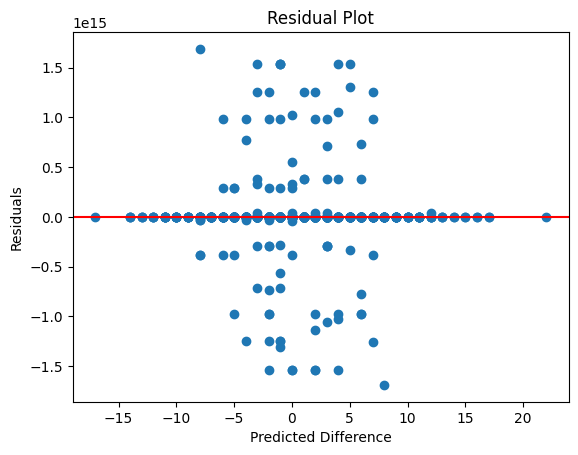

In [44]:
# GLM: Linear Regression (goal difference)
glm_forumula = (''' homegoals ~ hometeam_id + visitorteam_id ''')

y, X = dmatrices(glm_forumula, data=df_season, return_type='dataframe')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=1)


glm_LR = LinearRegression()
glm_LR.fit(X_train, y_train['homegoals'])

pred = pd.DataFrame(glm_LR.predict(X), columns=['pred_home'])
out = pd.concat([df_season, pred], axis=1)


out2 = out[['game_id', 'visitorteam_id', 'pred_home']].rename(columns={'visitorteam_id': 'hometeam_id', 'pred_home': 'pred_visitor'})
out_full = pd.merge(out, out2, on=['game_id', 'hometeam_id'])
del out, out2

out_full['pred_diff'] = out_full['pred_home'] - out_full['pred_visitor']
out_full = out_full[(out_full['keep'] == '1')]


print('R2: ', round(r2_score(out_full['goal_diff'], out_full['pred_diff']), 4))
print('MAE: ', round(mae(out_full['goal_diff'], out_full['pred_diff']), 4))


plt.scatter(out_full['goal_diff'], out_full['pred_diff'])
plt.xlabel('Goal Difference')
plt.ylabel('Predicted Goal Difference')
plt.title('Predicted vs Actual Goal Difference')
plt.show()


residuals = out_full['goal_diff'] - out_full['pred_diff']

plt.scatter(out_full['goal_diff'], residuals)
plt.xlabel('Predicted Difference')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

In [100]:
out_full[(out_full['game_id']=='2238756')]

,date,game_number,game_type,game_id,hometeam_id,hometeam_name,hometeam_division,visitorteam_id,visitorteam_name,visitorteam_division,homegoals,visitorgoals,keep,goal_diff,pred_home,pred_visitor,pred_diff
1,2025-02-15,6950204,Regular Season,2238756,251274,Northern Cyclones Squirt Minor Gold,10U Tier 4,248303,Keene 10U White,10U Tier 4,6,4,1,2,3.0,1.0,2.0
